In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
path = '../../data/processed/merged_mbta_weather.csv'
df = pd.read_csv(path)
print(df.head())

  service_date station_name  gated_entries  tavg  tmin  tmax  prcp  wspd
0   2018-01-01      Airport         3236.0 -14.7 -17.7 -10.5   0.0  26.3
1   2018-01-01      Alewife         1416.0 -14.7 -17.7 -10.5   0.0  26.3
2   2018-01-01       Andrew         1310.0 -14.7 -17.7 -10.5   0.0  26.3
3   2018-01-01     Aquarium         1801.0 -14.7 -17.7 -10.5   0.0  26.3
4   2018-01-01    Arlington         1576.0 -14.7 -17.7 -10.5   0.0  26.3


In [47]:
# Define MBTA line colors and their stations (in actual line order)
line_colors = {
    'Red': ['Alewife', 'Davis', 'Porter', 'Harvard', 'Central', 'Kendall', 'Charles/MGH', 'Park Street', 
            'Downtown Crossing', 'South Station', 'Broadway', 'Andrew', 'JFK/UMass', 'Savin Hill',
            'Fields Corner', 'Shawmut', 'Ashmont', 'North Quincy', 'Wollaston', 'Quincy Center', 
            'Quincy Adams', 'Braintree'],
    'Green': ['Lechmere', 'Science Park', 'North Station', 'Haymarket', 'Government Center', 
              'Park Street', 'Boylston', 'Arlington', 'Copley', 'Hynes', 'Kenmore', 'Prudential',
              'Symphony', 'Northeastern', 'Museum of Fine Arts', 'Longwood Medical Area', 'Brigham Circle',
              'Fenwood Road', 'Mission Park', 'Riverway', 'Back of the Hill', 'Heath Street', 'Cleveland Circle',
              'Beaconsfield', 'Reservoir', 'Chestnut Hill', 'Newton Centre', 'Boston College'],
    'Orange': ['Oak Grove', 'Malden Center', 'Wellington', 'Assembly', 'Sullivan Square', 'Community College',
              'North Station', 'Haymarket', 'State', 'Downtown Crossing', 'Chinatown', 'Tufts Medical Center',
              'Back Bay', 'Massachusetts Avenue', 'Ruggles', 'Roxbury Crossing', 'Jackson Square',
              'Stony Brook', 'Green Street', 'Forest Hills'],
    'Blue': ['Wonderland', 'Revere Beach', 'Beachmont', 'Suffolk Downs', 'Orient Heights', 'Wood Island',
            'Airport', 'Maverick', 'Aquarium', 'State', 'Government Center', 'Bowdoin'],
    'Silver': ['South Station', 'Courthouse', 'World Trade Center', 'Silver Line Way', 'Design Center']
}

In [48]:
# Assign line colors to stations once
def assign_line_colors(df, line_colors):
    """Assign MBTA line colors to stations in the dataframe"""
    df['line_color'] = 'Other'  # Default value
    for color, stations in line_colors.items():
        for station in stations:
            mask = df['station_name'].str.contains(station, case=False, na=False)
            df.loc[mask, 'line_color'] = color
    return df

In [49]:
# Function to create ordered station lists for each line
def get_ordered_stations(line_df, reference_stations):
    """Create ordered station list based on reference stations order"""
    stations = line_df['station_name'].unique()
    ordered_stations = []
    
    # Match actual stations with reference stations in order
    for ref_station in reference_stations:
        for actual_station in stations:
            if ref_station.lower() in actual_station.lower():
                ordered_stations.append(actual_station)
                break
    
    # Add any remaining stations
    for station in stations:
        if station not in ordered_stations:
            ordered_stations.append(station)
            
    return ordered_stations

In [50]:
# Function to visualize entries by weather feature
def visualize_by_weather_feature(df, feature_name, bin_size, palette_name, title_suffix):
    """Create visualizations for each line color grouped by a weather feature"""
    # Create bins for the weather feature
    bin_column = f"{feature_name}_bin"
    df[bin_column] = (df[feature_name] // bin_size) * bin_size
    
    # For each line color, create one comprehensive graph
    for color in sorted(df['line_color'].unique()):
        # Filter stations for this line color
        line_df = df[df['line_color'] == color]
        if len(line_df) == 0 or color == 'Other':  # Skip empty or "Other" lines
            continue
        
        # Create a larger figure
        plt.figure(figsize=(20, 10))
        
        # Get ordered stations for this line
        reference_stations = line_colors.get(color, [])
        ordered_stations = get_ordered_stations(line_df, reference_stations)
        
        # Create categorical type with custom order
        station_cat = pd.CategoricalDtype(categories=ordered_stations, ordered=True)
        
        # Convert station_name to categorical using custom order
        temp_df = line_df.copy()
        temp_df['station_name'] = temp_df['station_name'].astype(station_cat)
        
        # Create bar plot with ordered stations
        sns.barplot(data=temp_df, x="station_name", y="gated_entries", hue=bin_column, 
                   palette=palette_name, errorbar=None)
        
        # Customize plot
        plt.xticks(rotation=90)
        plt.xlabel("Stations (in Line Order)")
        plt.ylabel("Gated Entries")
        plt.title(f"{color} Line - All Stations Gated Entries by {title_suffix}")
        plt.legend(title=f"{feature_name.upper()} Bins")
        plt.tight_layout()
        plt.show()
    # Create aggregate visualization
    plt.figure(figsize=(12, 6))
    line_avg = df.groupby(['line_color', bin_column])['gated_entries'].mean().reset_index()
    sns.barplot(data=line_avg, x="line_color", y="gated_entries", hue=bin_column, 
               palette=palette_name, errorbar=None)
    plt.xlabel("Line Color")
    plt.ylabel("Average Gated Entries")
    plt.title(f"Average Gated Entries by Line and {title_suffix}")
    plt.legend(title=f"{feature_name.upper()} Bins")
    plt.tight_layout()
    plt.show()

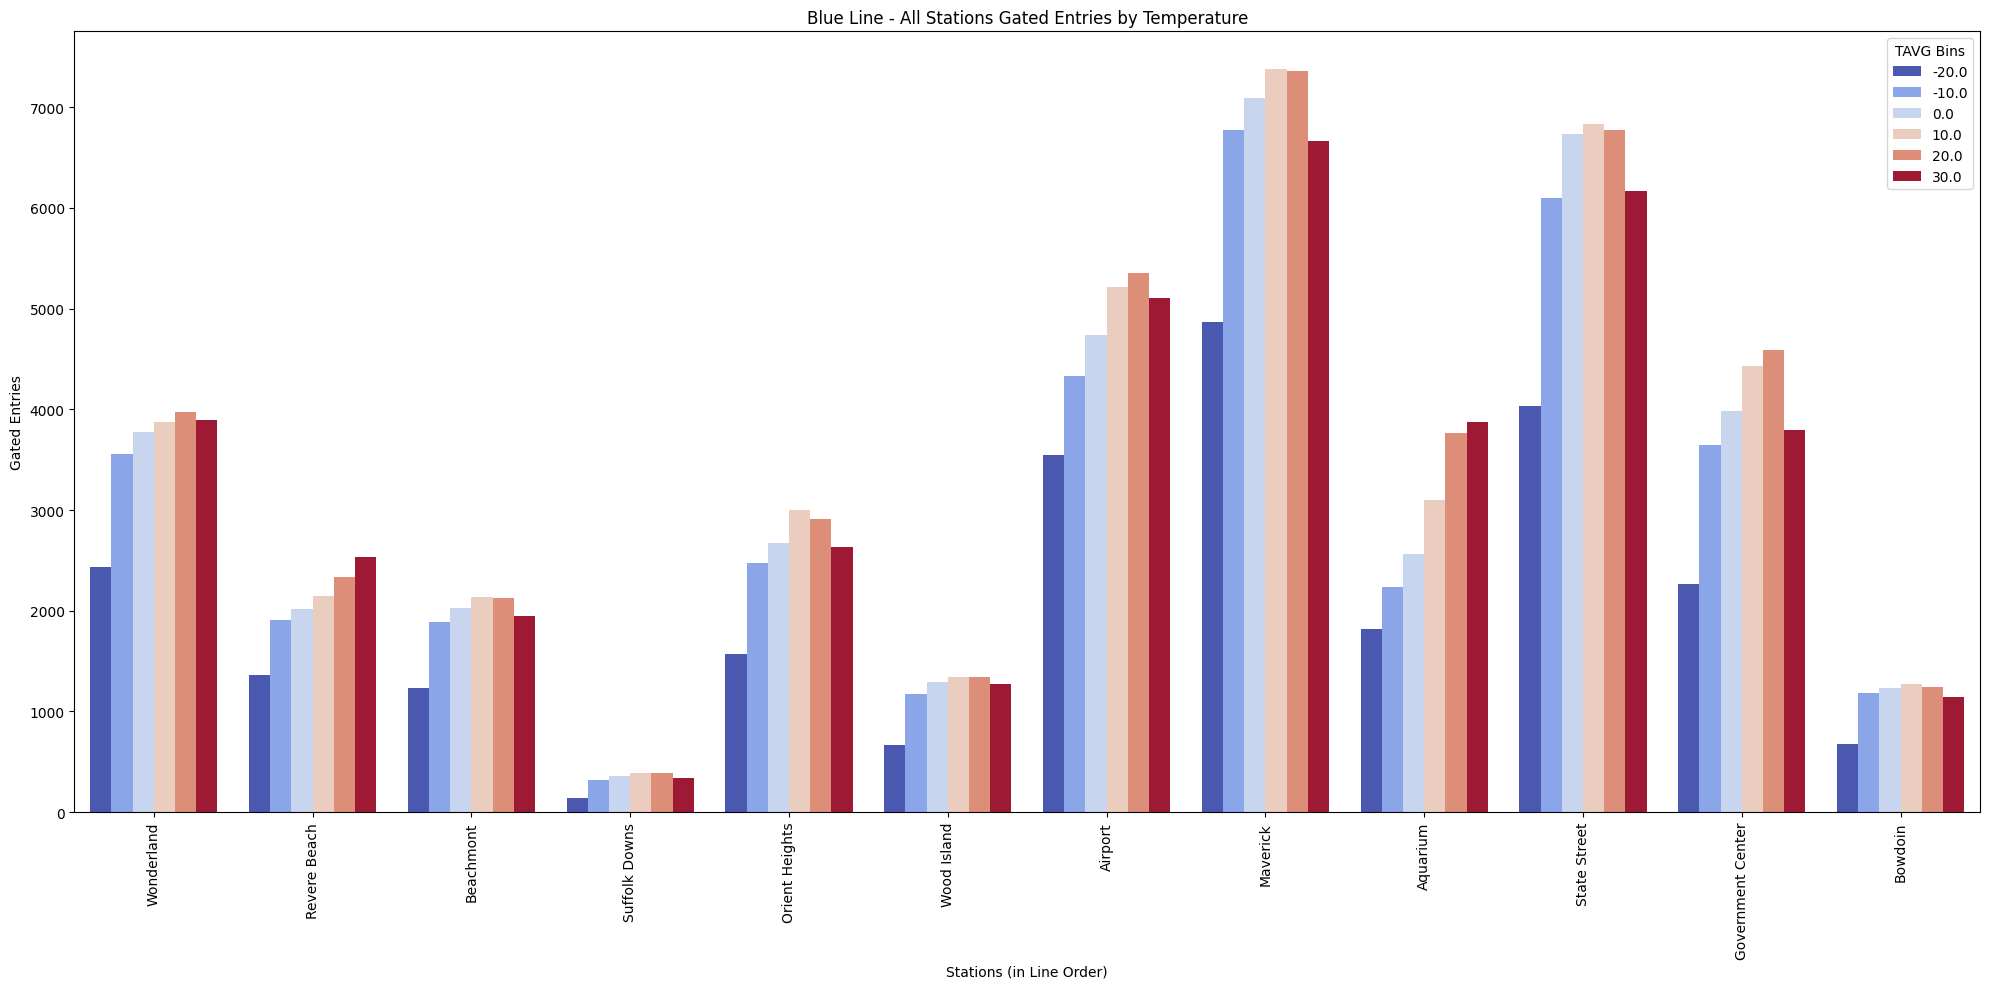

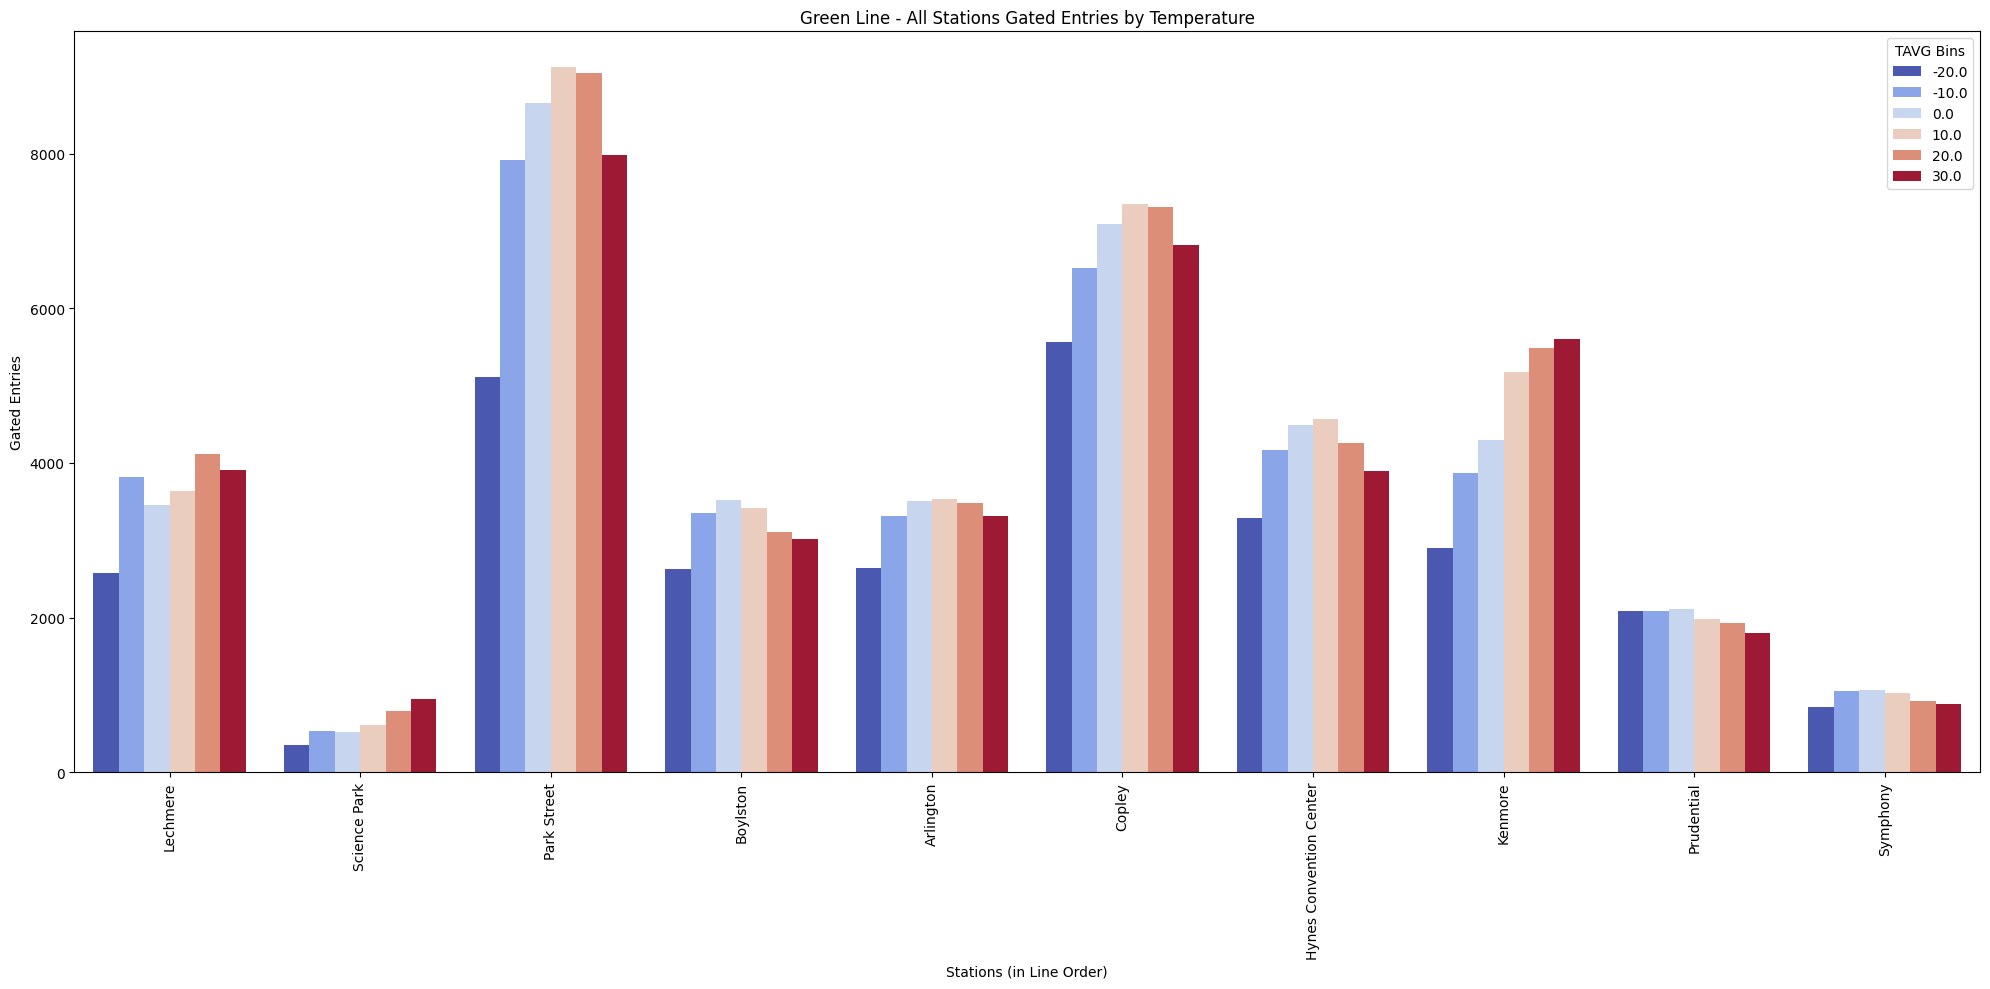

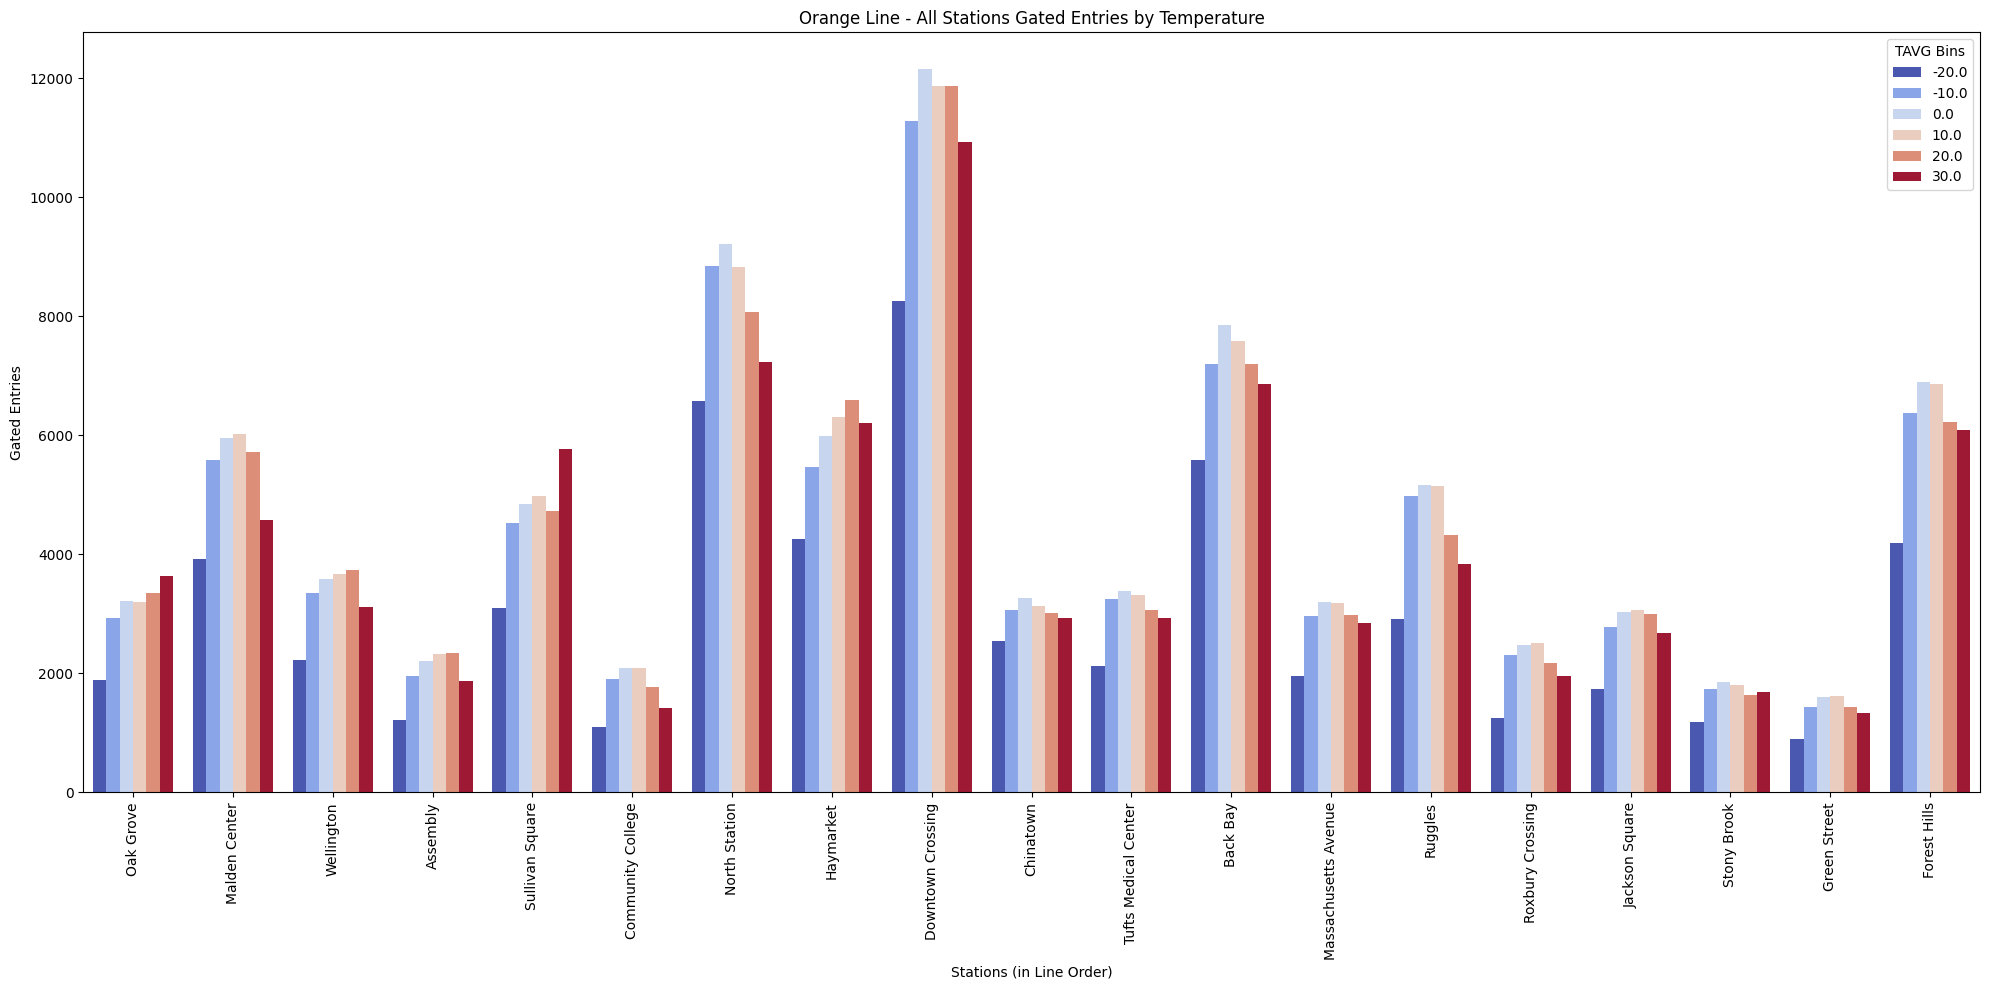

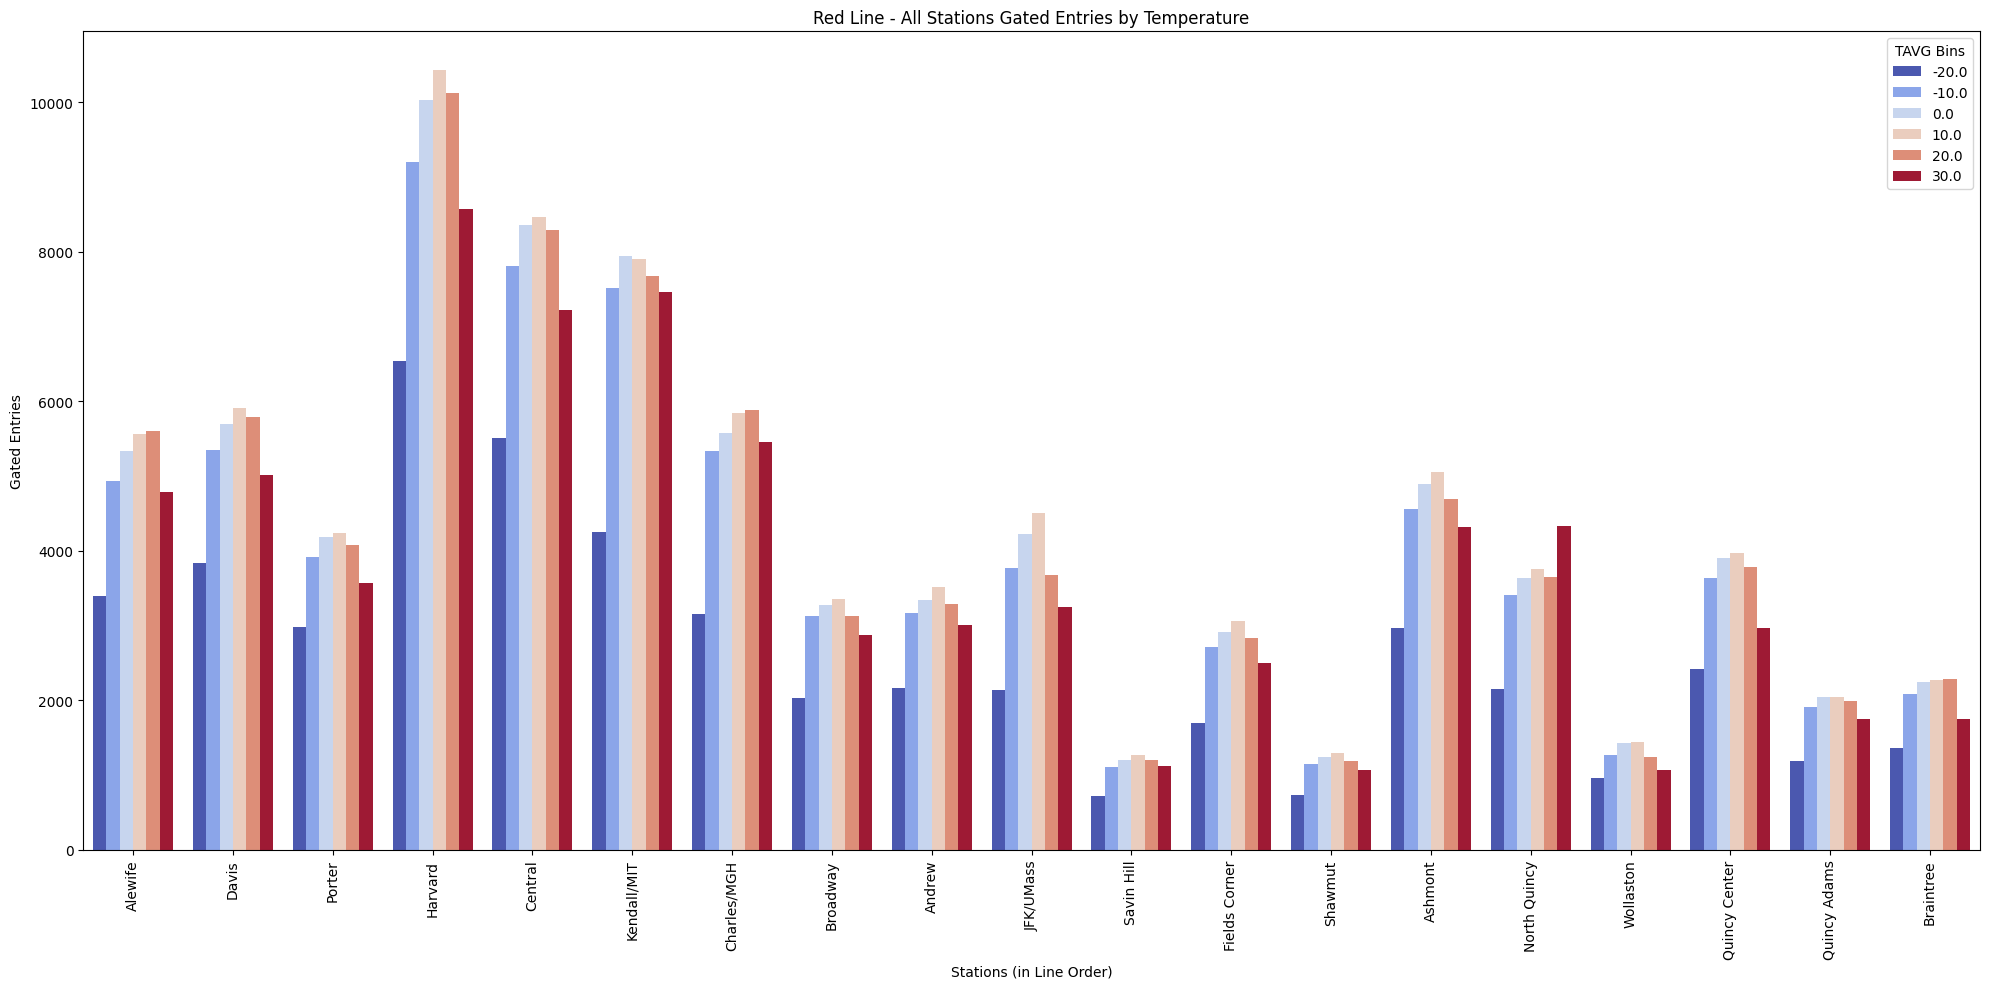

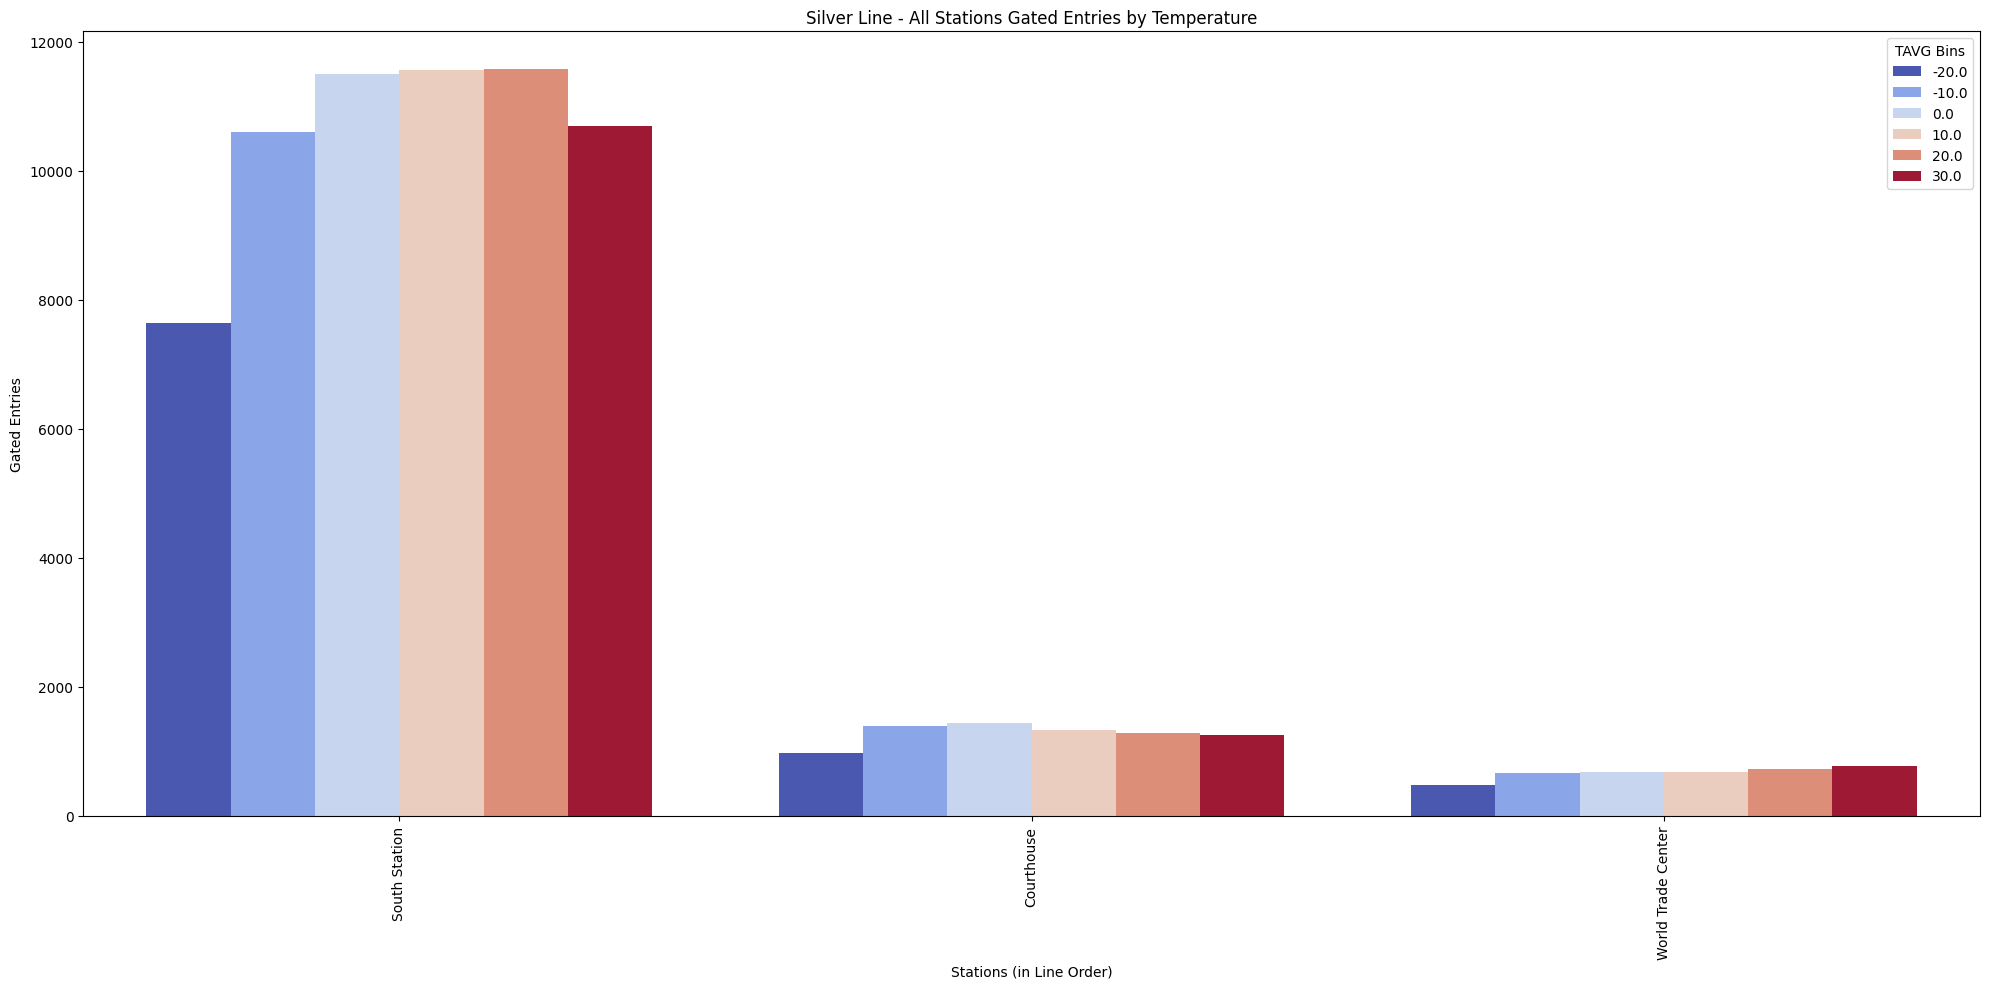

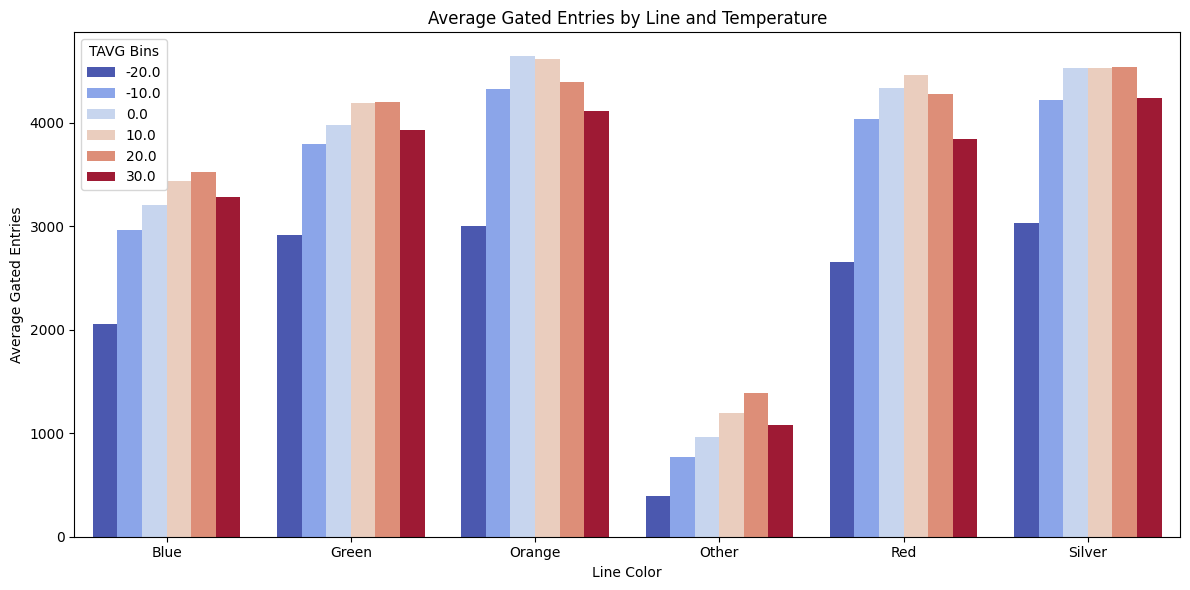

In [52]:
# Assign line colors to the dataframe
df = assign_line_colors(df, line_colors)

# Visualize entries by temperature
visualize_by_weather_feature(
    df=df,
    feature_name="tavg",
    bin_size=10,
    palette_name="coolwarm", 
    title_suffix="Temperature"
)

We can see a proper curve as the number of gated entries decreases. In certain places, like the aquarium and river beach, the numbers increase along with the temperatures. There might be a correlation because visits might increase due to the summer.

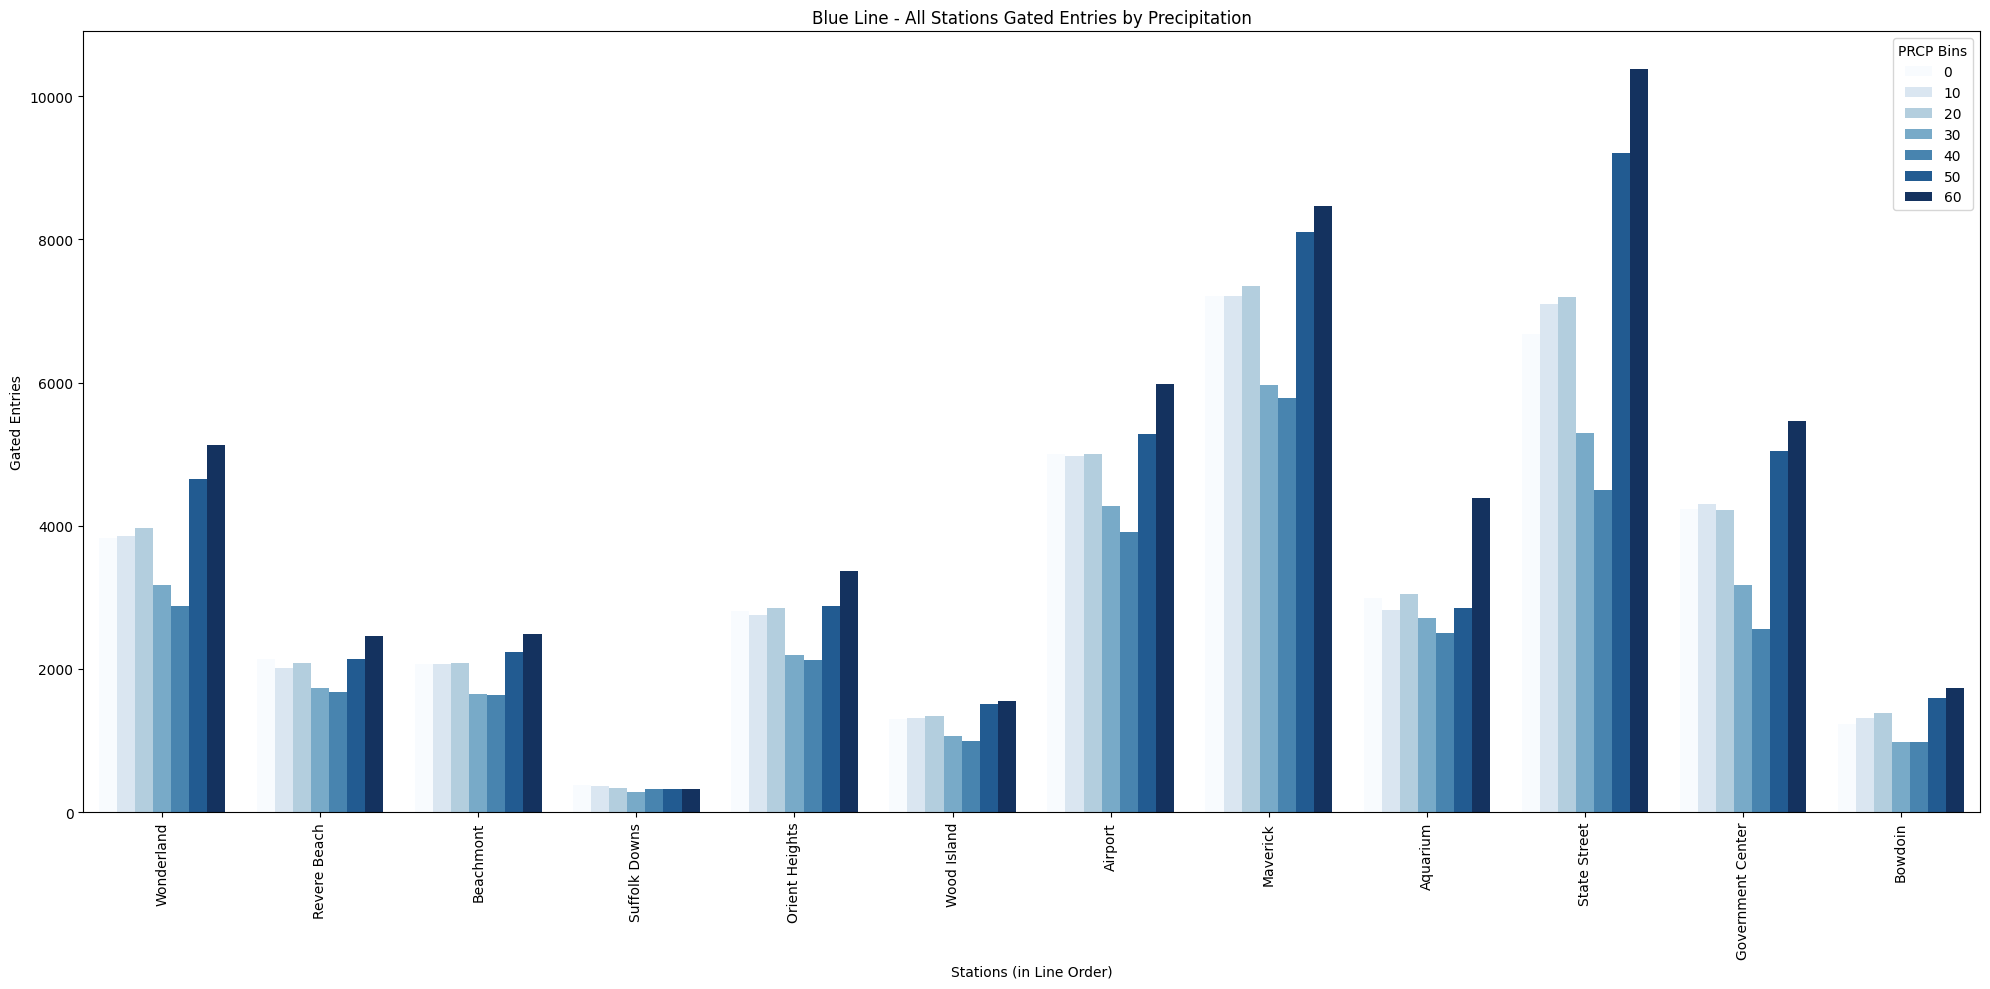

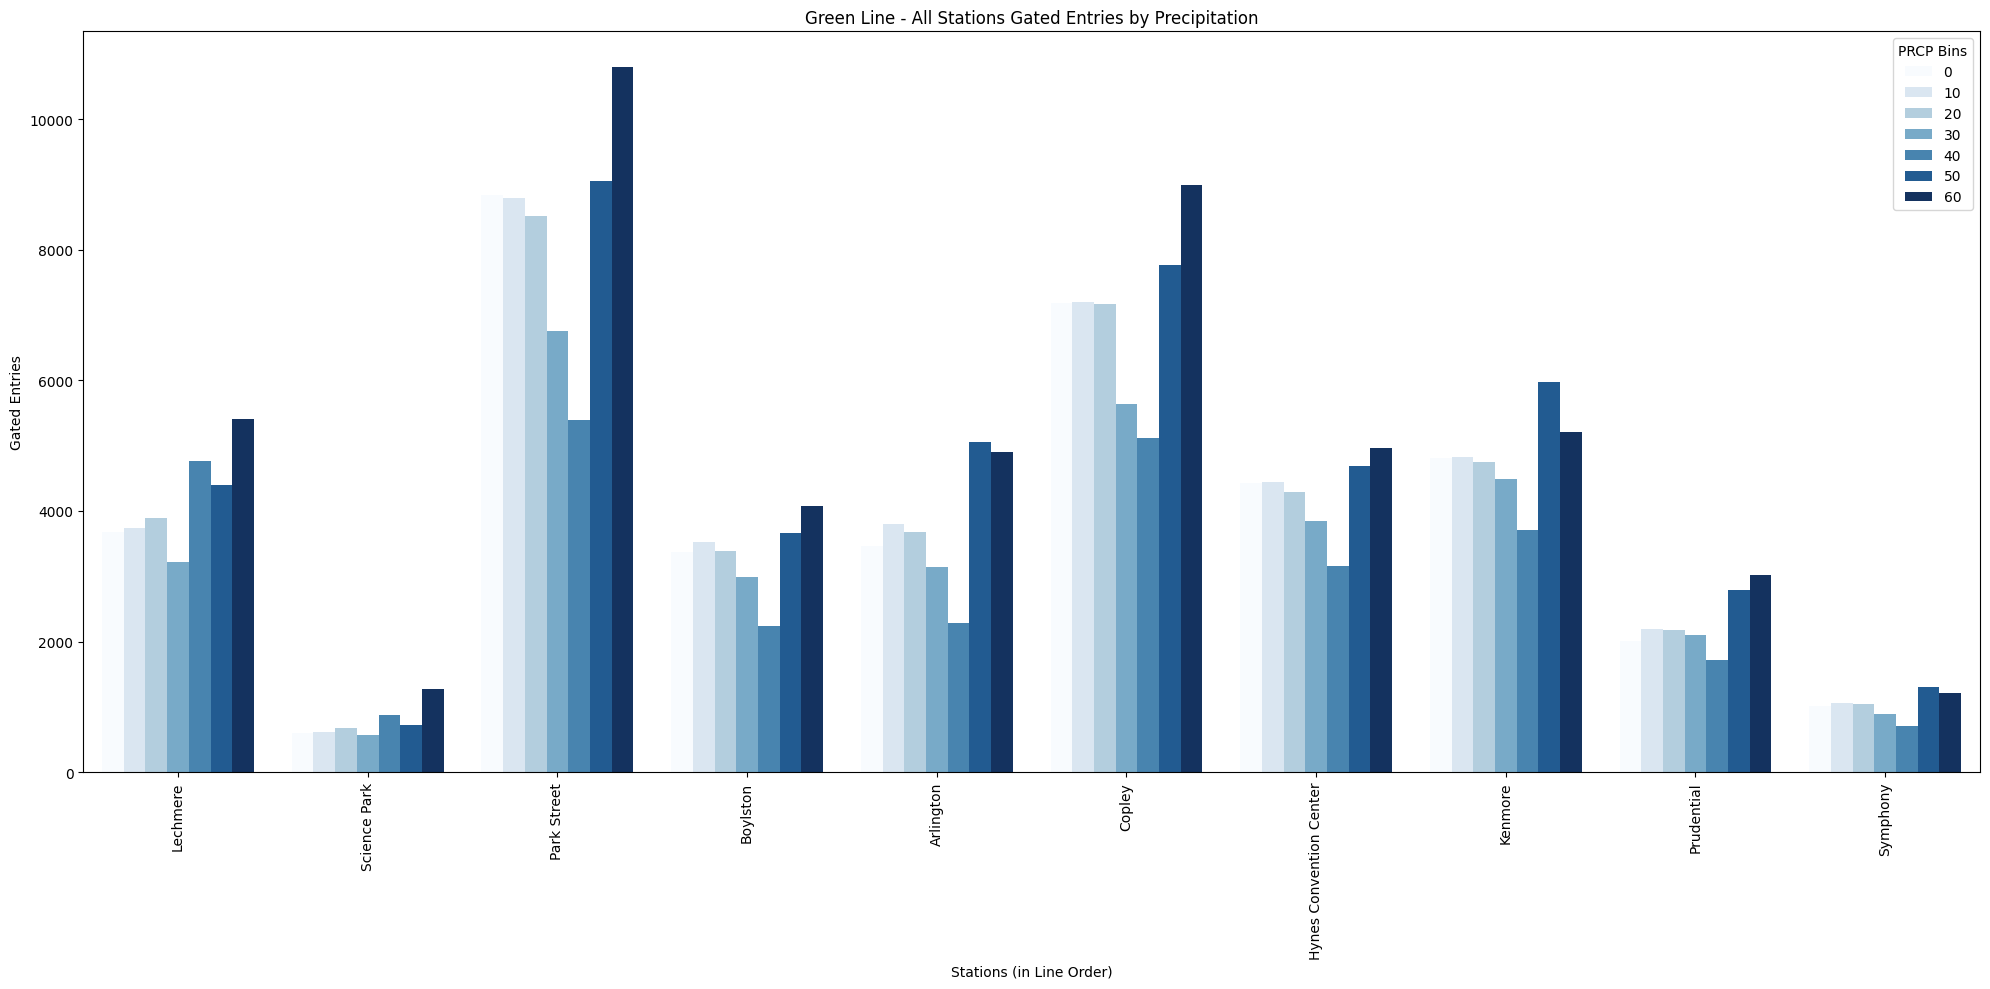

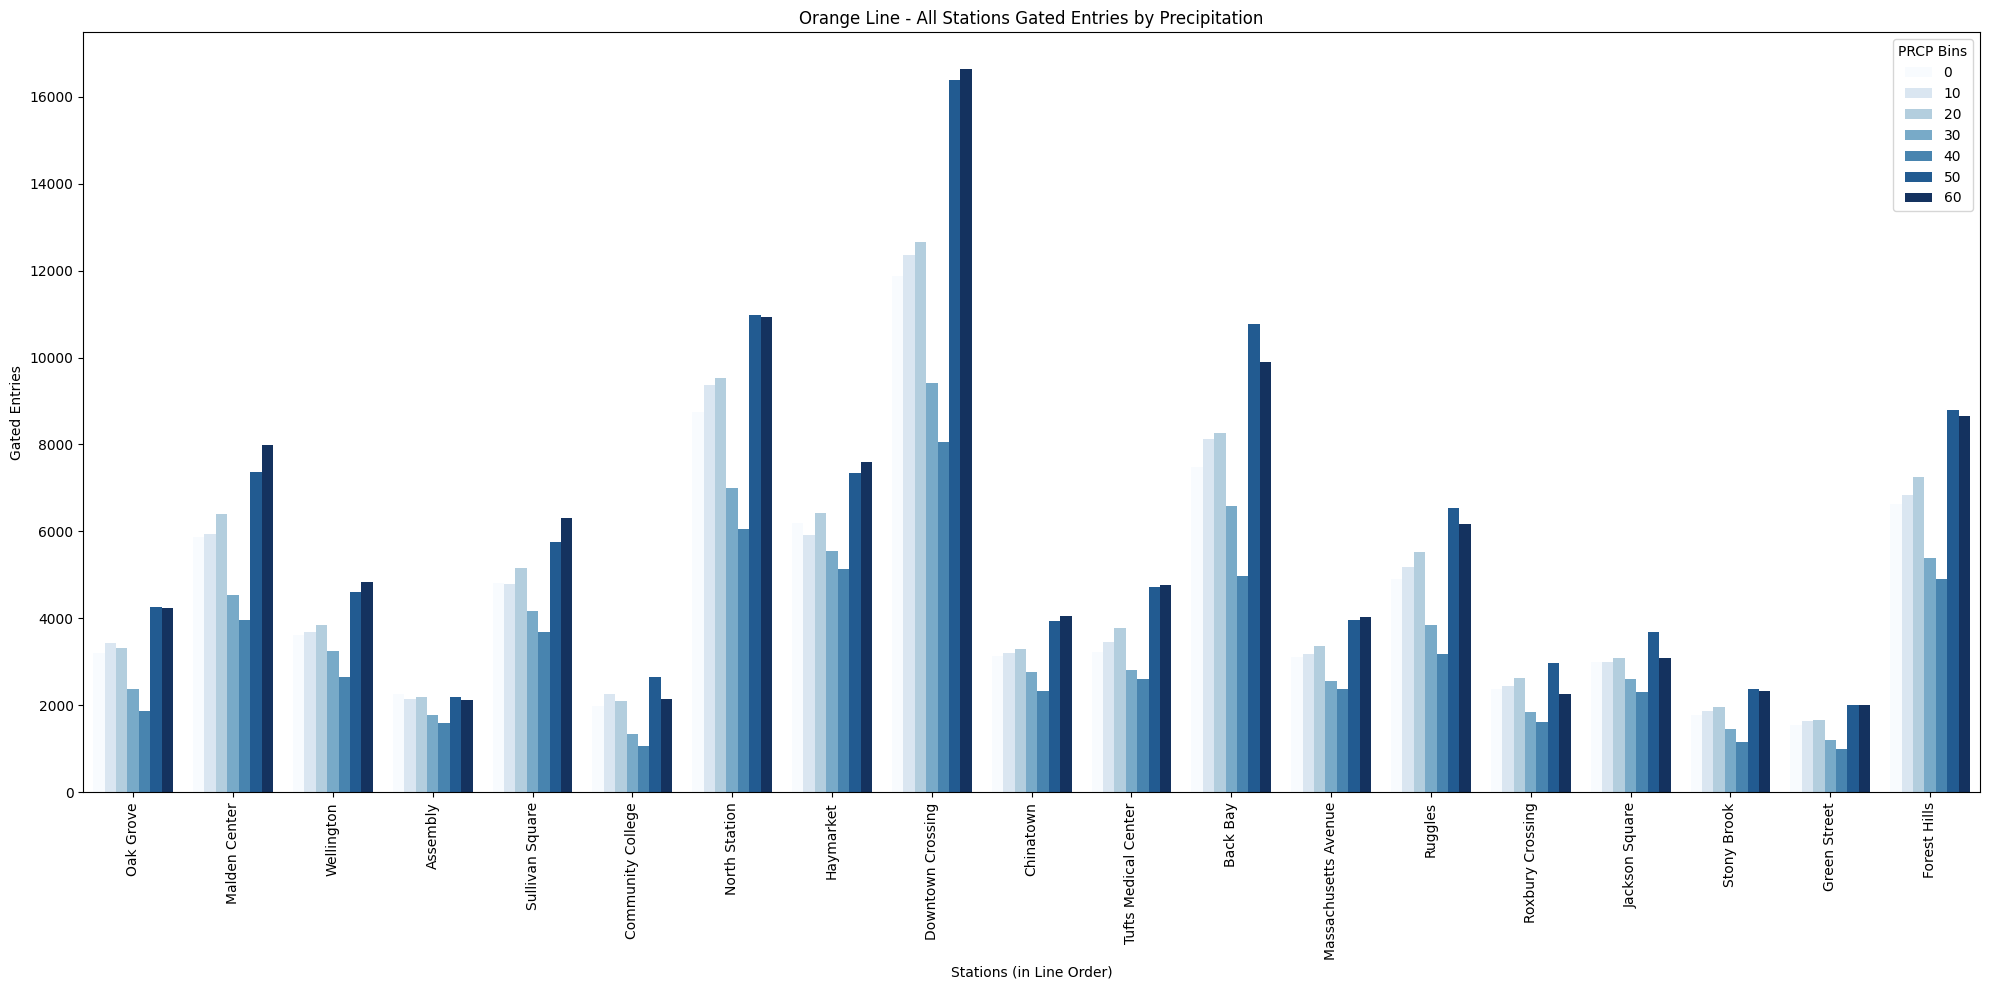

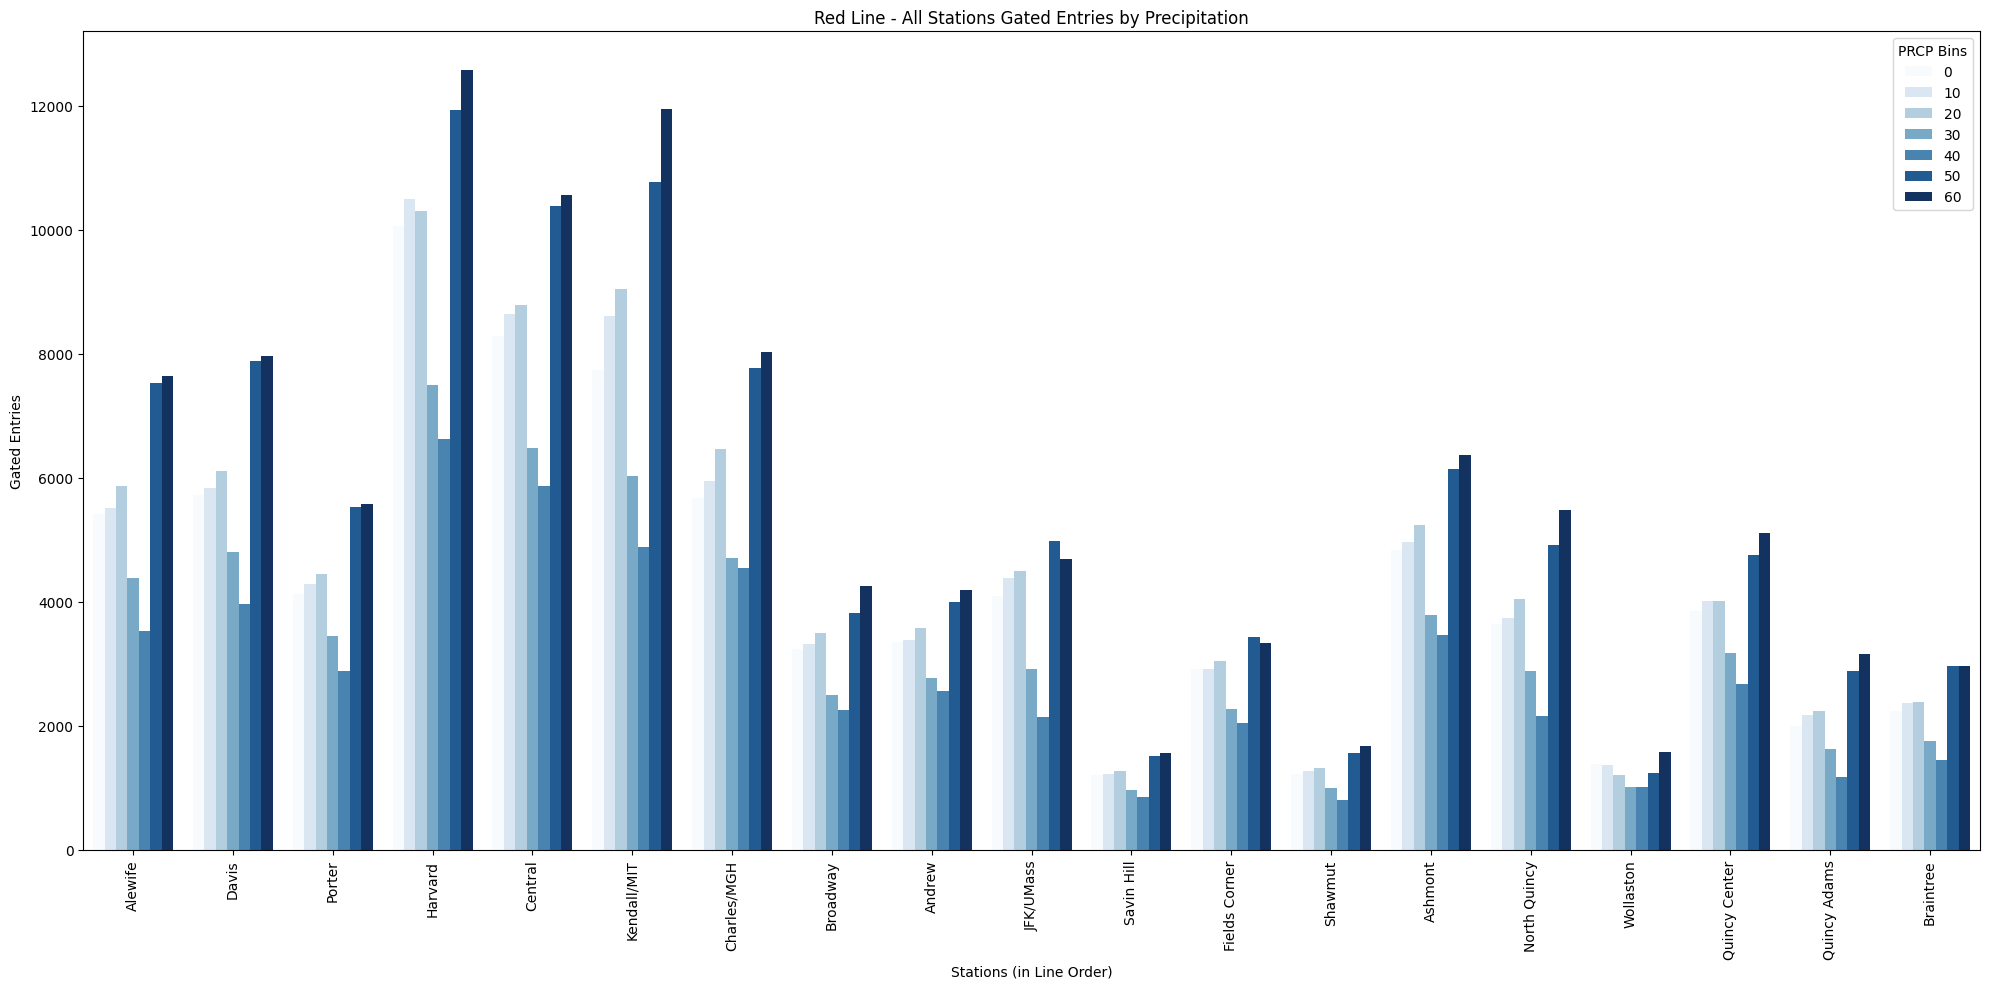

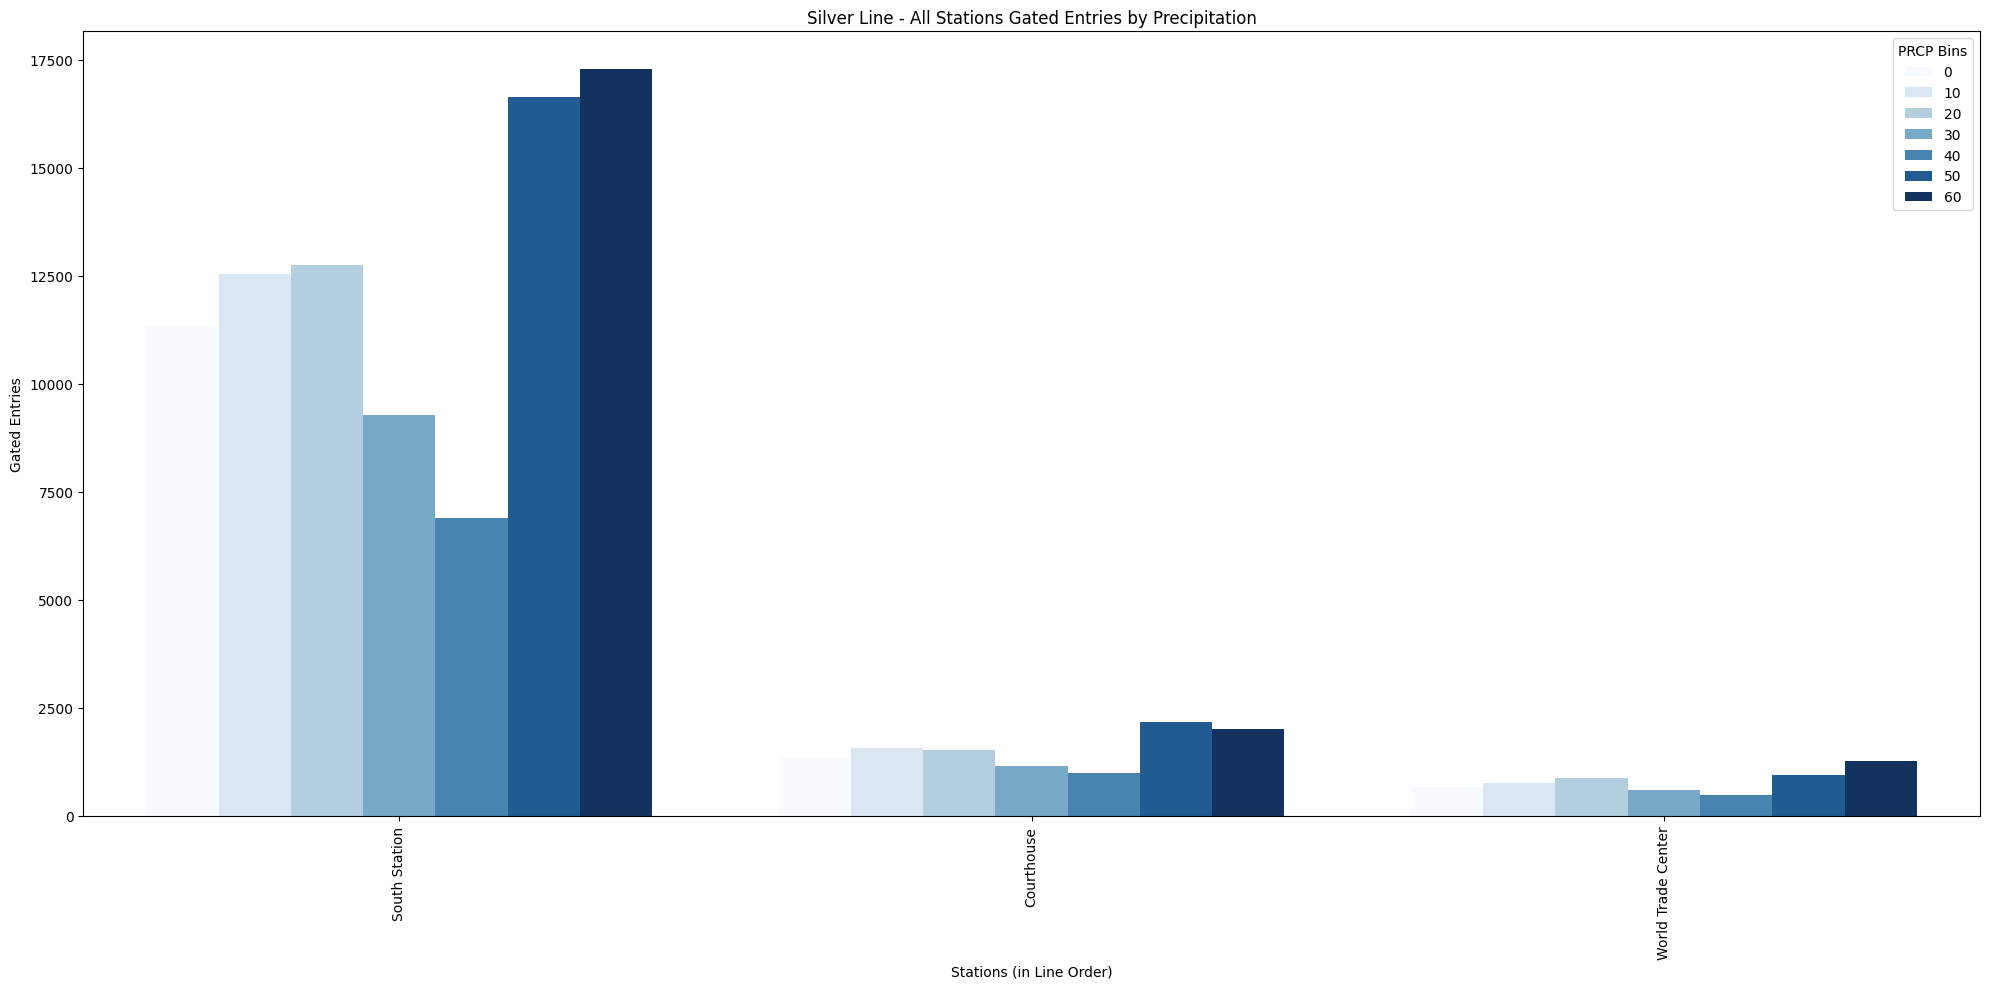

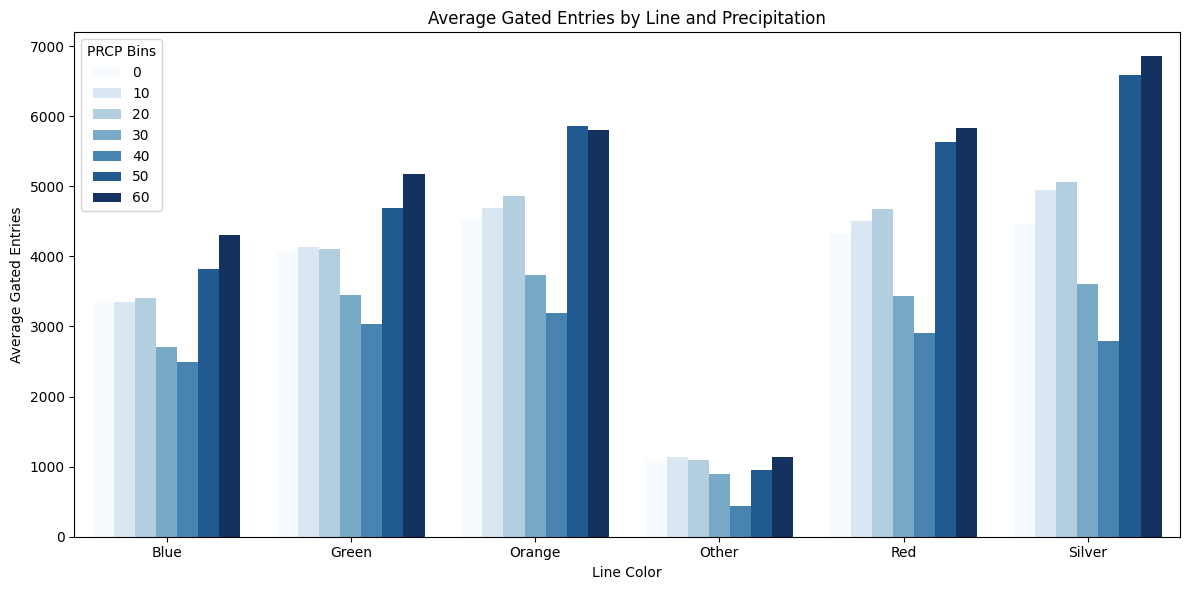

In [53]:
# Visualize entries by precipitation
visualize_by_weather_feature(
    df=df,
    feature_name="prcp",
    bin_size=10,
    palette_name="Blues",
    title_suffix="Precipitation"
)


There is a common trend where, during initial precipitation levels (0 to 30mm)—ranging from no rainfall to light rain—people continue commuting as usual. However, at 40mm, due to heavy rainfall, many prefer using cars instead of public transport. At 60mm, during extreme rain or snowstorms, people are more likely to choose trams or public transit over cars due to safety and road conditions.

In [ ]:
# Visualize entries by wind speed
visualize_by_weather_feature(
    df=df,
    feature_name="wspd",
    bin_size=5,
    palette_name="Greens",
    title_suffix="Wind Speed"
)

This trend is similar to precipitation patterns, and there is also a correlation with wind conditions.